## 1. ndarray

In [1]:
from mxnet import nd

/home/dluser1/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# row vector
x = nd.arange(12)
x


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
<NDArray 12 @cpu(0)>

In [3]:
# boardcasting
a = nd.arange(3).reshape((3, 1))
b = nd.arange(2).reshape((1, 2))
a, b

(
 [[0.]
  [1.]
  [2.]]
 <NDArray 3x1 @cpu(0)>, 
 [[0. 1.]]
 <NDArray 1x2 @cpu(0)>)

In [4]:
a + b


[[0. 1.]
 [1. 2.]
 [2. 3.]]
<NDArray 3x2 @cpu(0)>

## 2. autogradient

In [5]:
from mxnet import autograd

In [6]:
x = nd.arange(4).reshape((4, 1))
# using attach_grade to allocate memory for gradient
x.attach_grad()

with autograd.record():
    y = 2 * nd.dot(x.T, x)

y.backward()

In [7]:
x.grad, x.grad == 4 * x

(
 [[ 0.]
  [ 4.]
  [ 8.]
  [12.]]
 <NDArray 4x1 @cpu(0)>, 
 [[1.]
  [1.]
  [1.]
  [1.]]
 <NDArray 4x1 @cpu(0)>)

In [8]:
def f(a):
    """
    if with python conditional and loop control, we can also calculate gradient
    """
    b = a * 2
    while b.norm().asscalar() < 1000:
        b = b * 2
    if b.sum().asscalar() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [9]:
a = nd.random.normal(shape=1)
a.attach_grad()
with autograd.record():
    c = f(a)
c.backward()

In [10]:
a.grad == c / a


[1.]
<NDArray 1 @cpu(0)>

In [11]:
a = nd.random.normal(shape=(2, 2))
a.attach_grad()
with autograd.record():
    c = f(a)
c.backward()

In [12]:
a.grad == c / a


[[1. 1.]
 [1. 1.]]
<NDArray 2x2 @cpu(0)>

In [13]:
# print autograd
print(dir(autograd))

['CFUNCTYPE', 'Function', 'Lock', 'MXCallbackList', 'NDArray', 'NDArrayHandle', 'POINTER', 'Symbol', 'SymbolHandle', '_GRAD_REQ_MAP', '_LIB', '_RecordingStateScope', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_ndarray_cls', '_parse_head', 'absolute_import', 'array', 'backward', 'c_array', 'c_array_buf', 'c_handle_array', 'c_int', 'c_void_p', 'cast', 'check_call', 'ctypes', 'division', 'get_symbol', 'grad', 'is_recording', 'is_training', 'mark_variables', 'mx_uint', 'pause', 'predict_mode', 'record', 'set_recording', 'set_training', 'string_types', 'traceback', 'train_mode']


## 3. Linear Regression by Manual GD

page 37-42

In [14]:
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random

%matplotlib inline

In [15]:
# generate dataset
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# bug: labels += gaussion noise with scale = 0.01, as 0.001 is too small, almost cost will be zero => 0.01 will better
labels += nd.random.normal(scale=0.01, shape=labels.shape)

In [16]:
features[0], labels[0]

(
 [-1.2347414 -1.771029 ]
 <NDArray 2 @cpu(0)>, 
 [7.744012]
 <NDArray 1 @cpu(0)>)

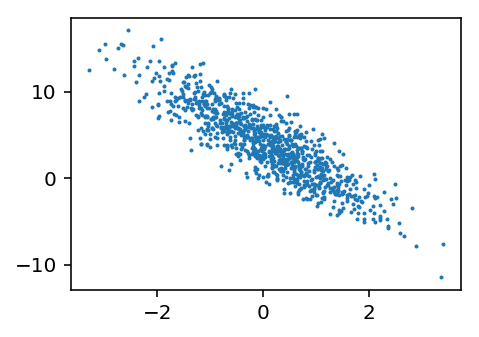

In [17]:
def set_figsize(figsize=(3.5, 2.5)):
    """
    analysis the linear relationship for different dimension.
    """
    # set retina
    set_matplotlib_formats('retina')
    # set size of graphic
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
# third parameter is c : color, sequence, or sequence of color, optional, default: ‘b’
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1)

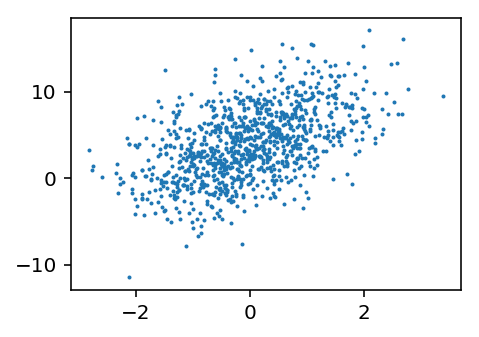

In [18]:
plt.scatter(features[:, 0].asnumpy(), labels.asnumpy(), 1)

In [19]:
batch_size = 10
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # read sample randomly
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        # take function to return elements
        yield features.take(j), labels.take(j)

In [20]:
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break


[[-0.8273198   1.0406365 ]
 [ 0.6360805  -0.5844077 ]
 [-1.0114343   2.112768  ]
 [-1.0267551   0.82085365]
 [-0.62958384  0.3508038 ]
 [-1.0747732  -0.15313894]
 [-1.1917231  -1.9933461 ]
 [-0.94586486  0.5678514 ]
 [ 0.7787424   0.6087823 ]
 [ 0.09161745  0.18294105]]
<NDArray 10x2 @cpu(0)> 
[-1.0072715   7.460776   -4.9972386  -0.65667355  1.7440273   2.5816202
  8.588414    0.39167407  3.6756487   3.7393224 ]
<NDArray 10 @cpu(0)>


In [21]:
# initialize w, b
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1, ))
params = [w, b]
# for params must attach for gradient descent
for param in params:
    param.attach_grad()

In [22]:
def linreg(X, w, b):
    return nd.dot(X, w) + b

In [23]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [24]:
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

### issue: why loss doesn't change

In [25]:
lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss

# training for num_epoches
for epoch in range(1, num_epochs + 1):
    #  using all samples in a batch
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            #  l is loss of (X, y) for a batch
            l = loss(net(X, w, b), y)
        # parameter gradient desent for batch
        l.backward()
        # using sgd for update parameters
        sgd([w, b], lr, batch_size)
    print('epoch %d, loss: %f' % (epoch, loss(net(features, w, b), labels).mean().asnumpy()))

epoch 1, loss: 0.040807
epoch 2, loss: 0.000161
epoch 3, loss: 0.000050
epoch 4, loss: 0.000050
epoch 5, loss: 0.000050
epoch 6, loss: 0.000050
epoch 7, loss: 0.000050
epoch 8, loss: 0.000050
epoch 9, loss: 0.000050
epoch 10, loss: 0.000050


In [26]:
true_w, w

([2, -3.4], 
 [[ 1.9999005]
  [-3.4004743]]
 <NDArray 2x1 @cpu(0)>)

In [27]:
true_b, b

(4.2, 
 [4.2002034]
 <NDArray 1 @cpu(0)>)

## 4. Linear Regression by Gluon

page 42-46

In [28]:
# generate dataset
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# bug: labels += gaussion noise with scale = 0.01, as 0.001 is too small, almost cost will be zero => 0.01 will better
labels += nd.random.normal(scale=0.01, shape=labels.shape)

In [29]:
from mxnet.gluon import data as gdata

In [30]:
batch_size = 10
dataset = gdata.ArrayDataset(features, labels)
data_iter = gdata.DataLoader(dataset, batch_size, shuffle=True)

In [31]:
for X, y in data_iter:
    print(X, y)
    break


[[ 1.6437836  -2.010241  ]
 [-0.2289262  -0.11356925]
 [-1.6563375  -1.4276173 ]
 [-1.1538591  -0.35195193]
 [ 0.2026782   1.4794393 ]
 [-0.6060944   1.6707205 ]
 [-0.24387665  0.80495137]
 [ 0.8345053  -0.5447224 ]
 [-0.38802934 -0.60260975]
 [ 0.99329066 -0.40947515]]
<NDArray 10x2 @cpu(0)> 
[14.317601    4.132272    5.7334485   3.0939977  -0.42859396 -2.681255
  0.97473514  7.7235994   5.4764304   7.5940046 ]
<NDArray 10 @cpu(0)>


In [32]:
from mxnet.gluon import nn
from mxnet import init
from mxnet import gluon
from mxnet.gluon import loss as gloss

In [33]:
net = nn.Sequential()
net.add(nn.Dense(1))
net.initialize(init.Normal(sigma=0.01))
loss = gloss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.03})

In [34]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
    print("epoch %d, loss = %f" % (epoch, loss(net(features), labels).mean().asnumpy()))

epoch 1, loss = 0.035155
epoch 2, loss = 0.000124
epoch 3, loss = 0.000050
epoch 4, loss = 0.000049
epoch 5, loss = 0.000049
epoch 6, loss = 0.000049
epoch 7, loss = 0.000049
epoch 8, loss = 0.000050
epoch 9, loss = 0.000049
epoch 10, loss = 0.000050


In [35]:
dense = net[0]
true_w, dense.weight.data()

([2, -3.4], 
 [[ 2.0004995 -3.4007158]]
 <NDArray 1x2 @cpu(0)>)

In [36]:
true_b, dense.bias.data()

(4.2, 
 [4.199507]
 <NDArray 1 @cpu(0)>)

## 5. Softmax Regression by Manual Code

page 51-58

In [37]:
import sys
# discussion result: https://discuss.gluon.ai/t/topic/6504
# library path https://github.com/mli/gluon-tutorials-zh/tree/master/gluonbook
sys.path.append("../gluon-tutorials-zh")

import gluonbook as gb
from mxnet import autograd, nd
from mxnet.gluon import data as gdata
import sys

In [38]:
# DATA SOURCE for training
mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)

In [39]:
feature, label = mnist_train[0]
feature.shape, feature.dtype

((28, 28, 1), numpy.uint8)

In [40]:
def show_fashion_images(images):
    _, figs = gb.plt.subplots(1, len(images), figsize=(15, 15))
    for f, img in zip(figs, images):
        f.imshow(img.reshape((28, 28)).asnumpy())
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

In [41]:
label, type(label), label.dtype

(2, numpy.int32, dtype('int32'))

In [42]:
def get_text_labels(labels):
    """
    convert int value of labels to text_labels.
    """
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[i] for i in labels]

['pullover', 'ankle boot', 'shirt', 't-shirt', 'dress', 'coat', 'coat', 'sandal', 'coat']


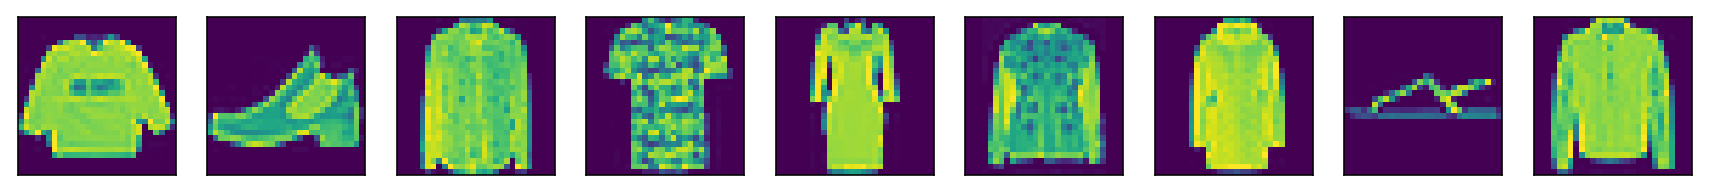

In [43]:
X, y = mnist_train[0:9]
show_fashion_images(X)
print(get_text_labels(y))

In [44]:
batch_size = 256
transformer = gdata.vision.transforms.ToTensor()
num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = gdata.DataLoader(mnist_train.transform_first(transformer), 
                             batch_size, shuffle=True,
                             num_workers=num_workers)
test_iter = gdata.DataLoader(mnist_test.transform_first(transformer), 
                             batch_size, shuffle=False,
                             num_workers=num_workers)

In [45]:
num_inputs = 784
num_outputs = 10

W = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b = nd.zeros(num_outputs)
params = [W, b]
for param in params:
    param.attach_grad()

In [46]:
# define softmax
X = nd.arange(1, 7).reshape((2, 3))
X.sum(axis=0, keepdims=True), X.sum(axis=1, keepdims=True)

(
 [[5. 7. 9.]]
 <NDArray 1x3 @cpu(0)>, 
 [[ 6.]
  [15.]]
 <NDArray 2x1 @cpu(0)>)

In [47]:
def softmax(X):
    """
    for X by exp(), then sum by row, divide by sum of row to get probablity for each category
    """
    exp = X.exp()
    partition = exp.sum(axis=1, keepdims=True)
    # using boardcasting to get probablity for each category
    return exp / partition

In [48]:
X = nd.random.normal(shape=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis=1)

(
 [[0.09240135 0.09818196 0.08506123 0.5392497  0.18510573]
  [0.08050614 0.5317458  0.08613493 0.11986954 0.18174359]]
 <NDArray 2x5 @cpu(0)>, 
 [1. 1.]
 <NDArray 2 @cpu(0)>)

In [49]:
# define model
def net(X):
    return softmax(nd.dot(X.reshape(-1, num_inputs), W) + b)

In [50]:
# define loss
y_hat = nd.array([[0.1, 0.3, 0.6], [0.3, .2, .5]])
y = nd.array([0, 2])
nd.pick(y_hat, y)


[0.1 0.5]
<NDArray 2 @cpu(0)>

In [51]:
def cross_entropy(y_hat, y):
    return -nd.pick(y_hat.log(), y)

In [52]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

In [53]:
accuracy(y_hat, y)

0.5

In [54]:
def evaluate_accuarcy(data_iter, net):
    acc = 0
    for X, y in data_iter:
        acc += accuracy(net(X), y)
    return acc / len(data_iter)

In [55]:
# as we randomize initial net, so it should be about 1 / num_ouputs = 0,1
evaluate_accuarcy(test_iter, net)

0.06083984375

In [ ]:
# training model
num_epochs = 5
lr = 0.1
loss = cross_entropy

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, trainer=None):
    for epoch in range(1, num_epochs + 1):
        train_l_sum = 0
        train_acc_sum = 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            if trainer is None:
                gb.sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)
            train_l_sum += l.mean().asscalar()
            train_acc_sum += accuracy(y_hat, y)
        test_acc = evaluate_accuarcy(test_iter, net)
        print("epoch %d, loss %.4f, train acc %.3f, test acc %.3f" % (epoch, train_l_sum / len(train_iter),
                                                                     train_acc_sum / len(train_iter), test_acc))

In [ ]:
## why here will be "Died Kernel"?
# issue : OpenBLAS : Program will terminate because you tried to start too many threads.
# suggestion: 
# 1. install the latest First reinstall the latest version of openblas with openmp
# 2. https://discuss.gluon.ai/t/topic/7858
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.7869, train acc 0.746, test acc 0.800
epoch 2, loss 0.5741, train acc 0.810, test acc 0.821


In [ ]:
# prediction
data, label = mnist_test[0:9]
show_fashion_images(data)
print('labels:', get_text_labels(label))
# bug: TypeError: list indices must be integers or slices, not numpy.float32
# predict_labels = [net(transformer(x)).argmax(axis=1).asscalar() for x in data]
predict_labels = [net(transformer(x)).argmax(axis=1).astype('int32').asscalar() for x in data]
print('predictions:', get_text_labels(predict_labels))

## 6. Softmax Regression by Gluon

page 59

In [ ]:
import gluonbook as gb
from mxnet import gluon, init
from mxnet.gluon import loss as gloss, nn

In [ ]:
batch_size = 256
train_iter, test_iter = gb.load_data_fashion_mnist(batch_size)

In [ ]:
# model defintion
net = nn.Sequential()
net.add(nn.Flatten())
net.add(nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))
loss = gloss.SoftmaxCrossEntropyLoss()

In [ ]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [ ]:
num_epochs = 5
gb.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, trainer)

In [ ]:
# prediction
data, label = mnist_test[0:9]
show_fashion_images(data)
print('labels:', get_text_labels(label))
# bug: TypeError: list indices must be integers or slices, not numpy.float32
# predict_labels = [net(transformer(x)).argmax(axis=1).asscalar() for x in data]
predict_labels = [net(transformer(x)).argmax(axis=1).astype('int32').asscalar() for x in data]
print('predictions:', get_text_labels(predict_labels))